In [1]:
import os
os.chdir('../')

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [3]:
torch.cuda.set_device(1)

In [4]:
path_appfeat512 = path/'appian_features_512'
path_appfeat512_tst = path/'appian_tst_features_512'

In [5]:
dls_feat = get_3d_dls_feat(Meta.df_comb, path=path_appfeat512, bs=32, meta=True)

In [14]:
type(dls_feat.train.dataset.)

fastai2.data.core.Datasets

In [ ]:
xb,yb = dls_feat.one_batch()

## Model

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, n_classes=6, embed_size=1024*4+1, LSTM_UNITS=1024*4+1, DO = 0.3):
        super(NeuralNet, self).__init__()
        
#         self.embedding_dropout = SpatialDropout(0.0) #DO)
        self.flat = nn.Sequential(AdaptiveConcatPool2d(), Flatten())
        self.hook = ReshapeBodyHook(self.flat)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

        self.linear = nn.Linear(LSTM_UNITS*2, n_classes)

    def forward(self, x):

#         x = torch.cat(x, axis=-1)
        x,pos = x
        x = x.view(*x.shape[:2], -1, 4, 4)
        h_embedding = torch.cat([self.flat(x), pos], axis=-1)
#         print(h_embedding.shape)
        h_embadd = torch.cat((h_embedding, h_embedding), -1)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
#         print([x.shape for x in [h_lstm1, h_lstm2, h_conc_linear1, h_conc_linear2, h_embadd]])
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2 + h_embadd

        output = self.linear(hidden)
        
        return output

In [9]:
m = NeuralNet()
name = 'train3d_adj_feat_lstm_2ndplace_meta'
learn = get_learner(dls_feat, m, name=name)
learn.add_cb(DePadLoss())

In [ ]:
# learn.summary()

## Training

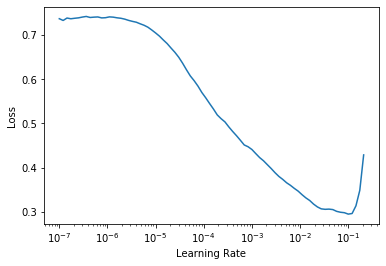

In [14]:
learn.lr_find()

In [9]:
do_fit(learn, 10, 1e-3)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.053768,0.053940,0.982142,0.966631,14:50
1,0.055694,0.054756,0.981149,0.966185,14:41
2,0.058119,0.057479,0.980905,0.965345,14:39
3,0.051553,0.058850,0.980364,0.960507,14:54
4,0.052655,0.053039,0.982604,0.967929,14:55
5,0.050558,0.057079,0.981327,0.963766,14:52
6,0.048639,0.052812,0.982535,0.965688,14:59
7,0.043698,0.051134,0.983088,0.968286,15:04
8,0.043665,0.050437,0.983205,0.968438,14:49
9,0.043822,0.050354,0.983358,0.968744,14:42


In [10]:
learn.load(f'runs/{name}-1')
do_fit(learn, 4, 1e-4)
learn.save(f'runs/{name}-2')

IndexError: list index out of range

## Testing

In [10]:
learn.dls = get_3d_dls_feat(Meta.df_tst, path=path_appfeat512_tst, bs=32, test=True, meta=True)

In [11]:
sub_fn = f'subm/{name}'
learn.load(f'runs/{name}-1')

In [12]:
preds,targs = learn.get_preds()
preds.shape, preds.min(), preds.max()

(torch.Size([121232, 6]), tensor(1.8321e-13), tensor(1.0000))

In [13]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [14]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:02<00:00, 9.99MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [18]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14385258,
 'totalBytes': 27277209,
 'date': '2020-02-05T07:36:08.903Z',
 'description': 'train3d_adj_feat_lstm_2ndplace_meta',
 'errorDescription': None,
 'fileName': 'train3d_adj_feat_lstm_2ndplace_meta.csv',
 'publicScore': '0.48679',
 'privateScore': '0.04842',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14385258/14385258.raw'}